# Внедрение моделей ML. Домашнее задание.

Маркетинговые агенства хотят проводить успешные рекламные кампании, но рынок сложен, что требует оценивать эффективности разных вариантов, что обуславливает необходимость проведения АБ-тестирования.

Компании заинтересованы в ответах на два вопроса:

1. Будет ли кампания успешной?
2. Если кампания была успешной, насколько этот успех можно объяснить рекламой?

Чтобы ответить на второй вопрос, мы обычно проводим A/B тестирование.

Большинство людей будут видеть рекламу (экспериментальная группа). А небольшая часть людей (контрольная группа) вместо этого увидит объявление государственной службы (PSA) (или ничего) точно такого же размера и в том же месте, где обычно находится реклама.


**Идея задания** состоит в том, чтобы проанализировать группы, выяснить, была ли реклама успешной, сколько компания может заработать на рекламе и является ли разница между группами статистически значимой.

Что нужно сделать   
- Проанализируйте структуру данных и проведите их предобработку.
- Сделайте первичный анализ результатов A/B-тестирования.
- Проведите статистический анализ результатов A/B-тестирования.

#### Словарь данных:


- **user id**: Идентификатор пользователя (уникальный).  
- **test group**: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.  
- **converted**: Если человек купил продукт, то True, иначе False.  
- **total ads**: Количество рекламы, увиденной человеком.  
- **most ads day**: День, в который человек увидел наибольшее количество рекламы.  
- **most ads hour**: Час дня, в который человек увидел наибольшее количество рекламы.  

##  Анализ структуры и предобработка данных
- Исследуйте структуру данных;
- Преобразуйте столбцы к необходимым типам данных.
- Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.
- Проверьте, есть ли пользователи, которые в процессе A/B теста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, kstest, norm, mannwhitneyu, t
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep, proportion_confint

In [3]:
df = pd.read_csv('marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


Уберем неинформативный столбец

In [4]:
df.drop(columns='Unnamed: 0')

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Пропусков нет

Проверим, есть ли пользователи, которые в процессе A/B теста попали в обе группы (и ad и psa)

In [6]:
df['test group'].value_counts()

,count
test group,
ad,564577
psa,23524


In [7]:
df['user id'].value_counts().sum()

np.int64(588101)

Количество уникальных идентифиакторов совпадает с числом строк в датасете, значит в датасете вероятно нет строк с повторяющимися идентификаторами пользователей

In [8]:
# Находим пользователей, которые есть в обеих группах
users_ad_group = set(df[df['test group'] == 'ad']['user id'].unique())
users_psa_group = set(df[df['test group'] == 'psa']['user id'].unique())

users_in_both_groups = users_ad_group & users_psa_group
print(f"Пользователи в обеих группах: {users_in_both_groups}")

Пользователи в обеих группах: set()


Действительно нет пользователей, попавших в обе группы

## Первичный анализ результатов A/B-тестирования
1. Рассчитайте вспомогательные показатели для контрольной и тестовой групп:

    - количество посещений сайта;
    - суммарное количество совершённых покупок;

Сделайте промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы? Можно ли говорить о сбалансированности выборок?

2. В каждой из групп рассчитайте ключевые показатели:

    - конверсия;
    - среднее количество рекламы, увиденной пользователем.
    
Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего количества увиденной рекламы в каждой из групп. По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

In [9]:
group_stats = df.groupby('test group').agg(
    total_visits_num=('user id', 'count'),         # Количество посещений сайта
    total_purchases=('converted', 'sum'),          # Суммарное количество совершённых покупок
    mean_ads=('total ads', 'mean'),                # Среднее количество рекламы, увиденной пользователем
    conversion_rate=('converted', 'mean')          # Конверсия
).round(3)

In [10]:
group_stats

,total_visits_num,total_purchases,mean_ads,conversion_rate
test group,,,,
ad,564577,14423,24.823,0.026
psa,23524,420,24.761,0.018


Количество посещений у группы ad больше количества посещений у группы psa в несколько раз (564 тыс. и 23 тыс.). Таким образом, выборки не сбалансированы.

При этом среднее количество рекламы, увиденнной пользователем в группах примерно одинаковое (~24 тыс.).
А на основе показателей конверсии можно сделать предварительный вывод о том, что вариант А - реклама (consersion_rate = 2.6%) эффективнее варианта B - объявления государственной службы (consersion_rate = 1.8%).


Однако из-за дисбаланса выборок результат может быть необъективным.
Из-за чего необходим дальнейший статистический анализ.

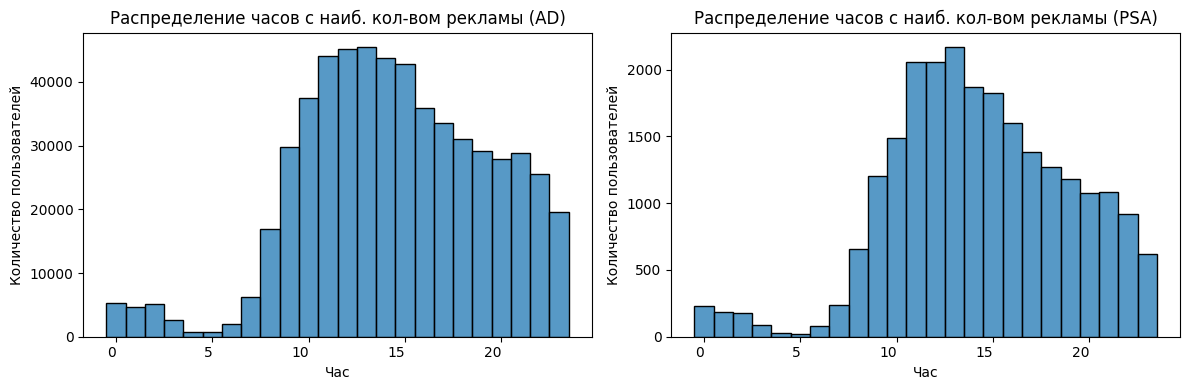

In [11]:
ad = df[df['test group'] == 'ad']
psa = df[df['test group'] == 'psa']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='most ads hour', data=ad, ax=axes[0], discrete=True)
sns.histplot(x='most ads hour', data=psa, ax=axes[1], discrete=True)

axes[0].set_title('Распределение часов с наиб. кол-вом рекламы (AD)')
axes[1].set_title('Распределение часов с наиб. кол-вом рекламы (PSA)')

for ax in axes:
    ax.set_xlabel('Час')
    ax.set_ylabel('Количество пользователей')
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()

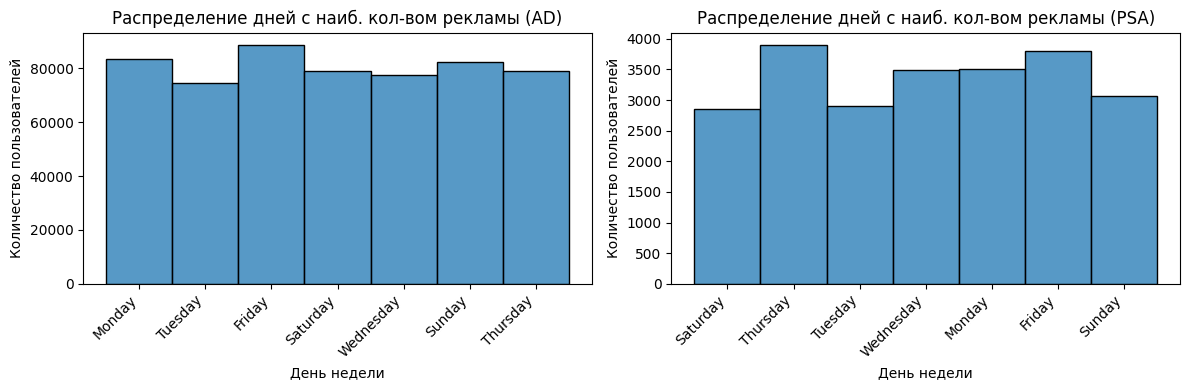

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='most ads day', data=ad, ax=axes[0], discrete=True)
sns.histplot(x='most ads day', data=psa, ax=axes[1], discrete=True)

axes[0].set_title('Распределение дней с наиб. кол-вом рекламы (AD)')
axes[1].set_title('Распределение дней с наиб. кол-вом рекламы (PSA)')

for ax in axes:
    ax.set_xlabel('День недели')
    ax.set_ylabel('Количество пользователей')
    # Поворачиваем подписи и выравниваем по правому краю
    ax.tick_params(axis='x', labelrotation=45, which='both')
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()

## Статистический анализ результатов A/B-тестирования
1. Сформулируйте статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберите статистический тест для их проверки.
Не забудьте проверить данные на нормальность там, где это необходимо.

2. С помощью аппарата статистических тестов определите:
    - Есть ли статистическая разница между конверсиями в группах А и B?
    - Есть ли статистическая разница между средними количествами увиденной рекламы в группах А и B?

3. Подкрепите результаты статистических тестов, построив 95 % доверительные интервалы для:
    - конверсий в каждой из групп;
    - разницы конверсий в группах;
    - среднего количества увиденной рекламы в группах А и B.

4. Проинтерпретируйте построенные доверительные интервалы для конверсий и среднего количества увиденной рекламы группах. Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

1. **статистические гипотезы, соответствующие поставленным бизнес-вопросам**

*1 бизнес-вопрос: Будет ли кампания успешной?*  
**Нулевая гипотеза H0**: Конверсия в группах ad и psa одинакова (т.е. нет статистически значимых различий, рекламная кампания не будет успешна).  
**Альтернативная гипотеза H1**: Конверсия в группе ad выше, чем в группе psa (т.е. рекламная кампания успешна).

*2 бизнес-вопрос: Если кампания была успешной, насколько этот успех можно объяснить рекламой?*  
**Нулевая гипотеза H0**: Среднее количество увиденной рекламы в группах ad и psa равны (т.е. нет статистически значимых различий, успех рекламной кампании можно объячснить рекламой).  
**Альтернативная гипотеза H1**: Среднее количество увиденной рекламы в группах ad и psa отличаются (т.е. статистическая разница есть, и успех рекламной кампании не объясняется одной рекламой).

2. **Проверим с помощью статистических тестов**  


Для конверсии берем Z-тест для пропорций, поскольку бинарные метрики (converted) и выборки большие.  
Для среднего числа увиденной рекламы в группах А и В (непрерывные метрики) проверяем данные на нормальность с помощью теста Шапиро-Уилка или Колмогорова-Смирнова, и если данные не нормальные, то U-тест Манна-Уитни.

In [18]:
# Суммарное количество совершённых покупок
purchases = [ad['converted'].sum(), psa['converted'].sum()]
# Количество посещений сайта
nobs = [len(ad), len(psa)]

z_stat, p_value = proportions_ztest(purchases, nobs, alternative='larger')
print(f"Z = {z_stat:.3f}, p-value = {p_value}")

alpha = 0.05

if p_value < alpha:
    print(f"Отвергаем H0 (p < {alpha})")
    print(f"Вывод: Конверсия в группе ad выше, чем в группе psa. Различия статистически значимы")
else:
    print(f"Не отвергаем H0 (p ≥ {alpha})")
    print("Вывод: Статистически значимой разницы в конверсии между группами ad и psa нет")

Z = 7.370, p-value = 8.526403580779863e-14
Отвергаем H0 (p < 0.05)
Вывод: Конверсия в группе ad выше, чем в группе psa. Различия статистически значимы


In [19]:
# Проверяем на нормальность
stats, p_value_x = stats.shapiro(df['total ads'])
print(f'статистика = {stats}, p-value = {p_value_x}')

# H0 - выборка нормальна
# H1 - выборка не нормальна

# Принятие решения на основе p-значения
if p_value_x < alpha:
    print(f"Отвергаем H0 (p < {alpha})")
    print("Выборка total ads не нормальна")
else:
    print(f"Не отвергаем H0 (p ≥ {alpha})")
    print("Нельзя отклонить нулевую гипотезу о нормальности для total ads")

статистика = 0.4801062979273719, p-value = 8.01101062764243e-204
Отвергаем H0 (p < 0.05)
Выборка total ads не нормальна


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 588101.
  res = hypotest_fun_out(*samples, **kwds)


Выборка не номральна, используем тест Манна-Уитни

In [32]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(ad['total ads'], psa['total ads'])
print(f"U = {u_stat}, p-value = {p_value}")

if p_value < alpha:
    print(f"Отвергаем H0 (p < {alpha})")
    print(f"Вывод: Среднее количество увиденной рекламы в группах ad и psa отличаются статистически значимо")
else:
    print(f"Не отвергаем H0 (p ≥ {alpha})")
    print("Вывод: Нет статистически значимых различий в среднем количестве увиденной рекламы в группах ad и psa")

U = 6808288222.0, p-value = 4.6909108547205694e-11
Отвергаем H0 (p < 0.5)
Вывод: Среднее количество увиденной рекламы в группах ad и psa отличаются статистически значимо


Тест обнаружил статистически значимые различия между группами, но значение U очень большое, что можно трактовать как нахождений даже самых маленьких глобально незначимых различий. Необходимо проверить доверительные интервалы перед тем как отвергать нулевую гипотезу.

3. **Подкрепим результаты статистических тестов, построив 95 % доверительные интервалы**

- для конверсий в каждой из групп;
- для разницы конверсий в группах;
- для среднего количества увиденной рекламы в группах А и B.

4. **Проинтерпретируем построенные доверительные интервалы для конверсий и среднего количества увиденной рекламы группах.**

Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

In [23]:
purchases

[np.int64(14423), np.int64(420)]

In [24]:
nobs

[564577, 23524]

In [27]:
# для конверсий в каждой из групп;
print(f"Конверсия в группе ad: {purchases[0] / nobs[0]}")
ci_low_ad, ci_upp_ad = proportion_confint(purchases[0], nobs[0], alpha=0.05)
print(f"Интервал конверсии в группе ad: [{ci_low_ad:.6f}, {ci_upp_ad:.6f}]")
print()
print(f"Конверсия в группе psa: {purchases[1] / nobs[1]}")
ci_low_psa, ci_upp_psa = proportion_confint(purchases[1], nobs[1], alpha=0.05)
print(f"Интервал конверсии в группе psa: [{ci_low_psa:.6f}, {ci_upp_psa:.6f}]")

Конверсия в группе ad: 0.025546559636683747
Интервал конверсии в группе ad: [0.025135, 0.025958]

Конверсия в группе psa: 0.01785410644448223
Интервал конверсии в группе psa: [0.016162, 0.019546]


Доверительные интервалы не перекрываются, следовательно разница статистически значима. Конверсия в группе ad выше.

In [29]:
# для разницы конверсий в группах;

low, upp = confint_proportions_2indep(purchases[0], nobs[0], purchases[1], nobs[1])
print(f"Интервал для разницы конверсий в группах ad и psa: [{low:.4f}, {upp:.4f}]")

Интервал для разницы конверсий в группах ad и psa: [0.0059, 0.0094]


Реклама увеличина конверсию на 0.6-0.9 процентных пунктов с 95% уверенностью

In [31]:
# для среднего количества увиденной рекламы в группах А и B.

alpha = 0.5

mean_ad, se_ad = ad['total ads'].mean(), np.std(ad['total ads']) / np.sqrt(len(ad['total ads']))
ci_ad = t.interval(1-alpha, len(ad['total ads'])-1, loc=mean_ad, scale=se_ad)
print(f"Интервал для количества рекламы в ad: [{ci_ad[0]:.4f}, {ci_ad[1]:.4f}]")

mean_psa, se_psa = psa['total ads'].mean(), np.std(psa['total ads']) / np.sqrt(len(psa['total ads']))
ci_psa = t.interval(1-alpha, len(psa['total ads'])-1, loc=mean_psa, scale=se_psa)
print(f"Интервал для количества рекламы в psa: [{ci_psa[0]:.4f}, {ci_psa[1]:.4f}]")

Интервал для количества рекламы в ad: [24.7841, 24.8626]
Интервал для количества рекламы в psa: [24.5727, 24.9496]


Доверительные интервалы перекрываются, следовательно нет статистически значимых различий. Частота показов рекламы рекламы не влияет на результат кампании. Успех рекламной кампании можно объячснить именно рекламой (ее эффектом).

### Вывод

1. Рекламная кампания будет успешной. Реклама успешно увеличила конверсию на 0.6-0.9 процентных пунктов. Результаты статистически значимы, что показывают тесты и доверительные интервалы выше.

2. Успех рекламной компании обоснован именно рекламой, а не другими факторами. Количество увиденной рекламы (частота показов) не повлияла на результат, поскольку различия в А и В группах оказались статистически не значимы.


